## Import Necessary Dependencies

In [1]:
!nvidia-smi

Fri Aug  2 11:01:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8               6W /  60W |    228MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Load the Data from the directory

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


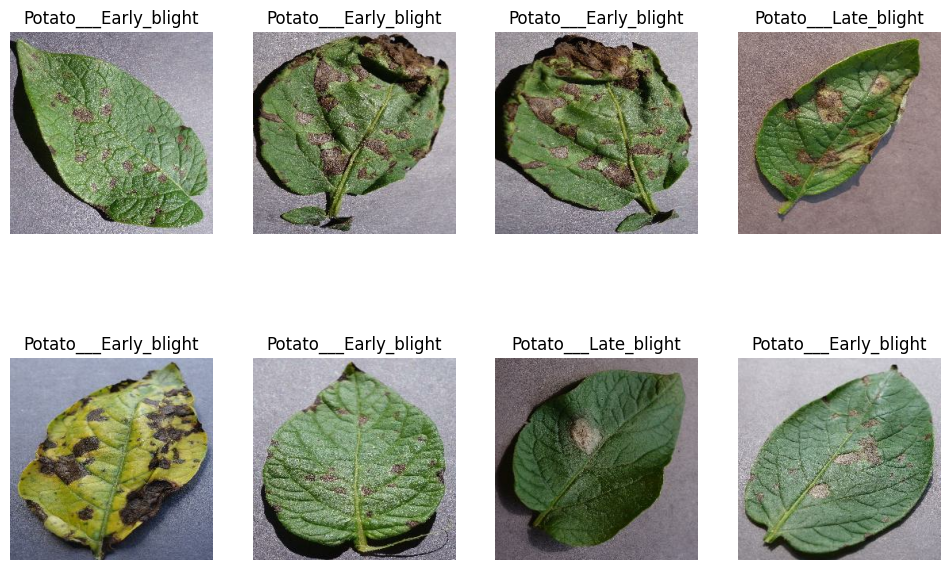

In [8]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

## Function to split the Data into Train, Test, Validation

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:#why shuffle to get a better model performance since it uses random samples
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)#Cache:speed training as it preserves the memory, for loading generally
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)#Large Images, prefetch helps for performance improvement.
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data Augmentation

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Model Architecture and Building

In [23]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import layers, models

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = DenseNet169(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape[1:]  
)


for layer in base_model.layers:
    layer.trainable = False


classification_head = models.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model = models.Sequential([
    resize_and_rescale,  # Assuming you have defined this layer
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape[1:]),  # Remove BATCH_SIZE
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.layers[-2].set_weights(classification_head.layers[1].get_weights())
model.layers[-1].set_weights(classification_head.layers[2].get_weights())

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 22s 221ms/step - loss: 0.9187 - accuracy: 0.4803 - val_loss: 0.8767 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 7s 123ms/step - loss: 0.8311 - accuracy: 0.5995 - val_loss: 0.7051 - val_accuracy: 0.6510
Epoch 3/50
54/54 [==============================] - 6s 113ms/step - loss: 0.5537 - accuracy: 0.7506 - val_loss: 0.4828 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 6s 111ms/step - loss: 0.3622 - accuracy: 0.8524 - val_loss: 0.5087 - val_accuracy: 0.8125
Epoch 5/50
54/54 [==============================] - 6s 111ms/step - loss: 0.3083 - accuracy: 0.8785 - val_loss: 0.2484 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 6s 111ms/step - loss: 0.2265 - accuracy: 0.9132 - val_loss: 0.2243 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 6s 111ms/step - loss: 0.1939 - accuracy: 0.9248 - val_loss: 0.2169 - val_accuracy: 0.9062
Epoch

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 52ms/step - loss: 5.4484e-04 - accuracy: 1.0000


In [28]:
scores

[0.0005448427982628345, 1.0]

## Accuracy vs Loss Graph

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9187490940093994,
 0.8311331868171692,
 0.5536661744117737,
 0.36219704151153564,
 0.3082525432109833]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

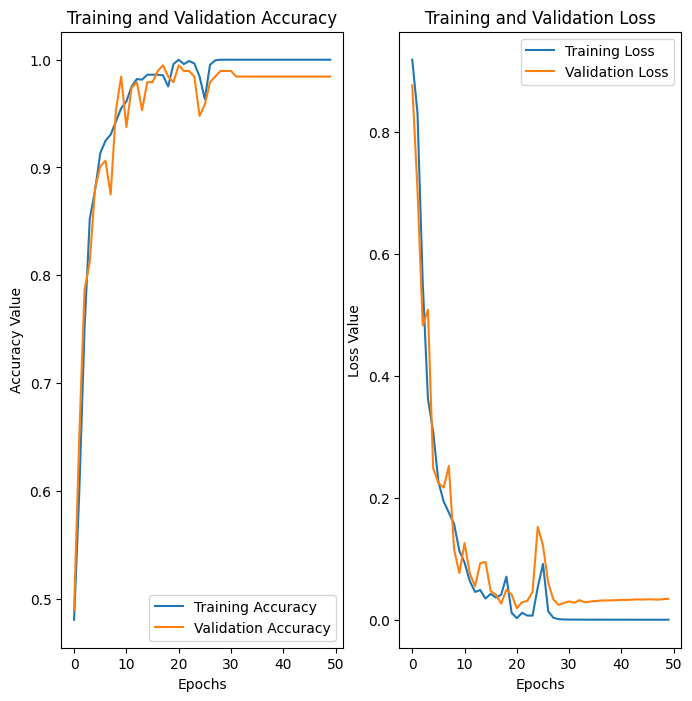

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 296ms/step
predicted label: Potato___Early_blight


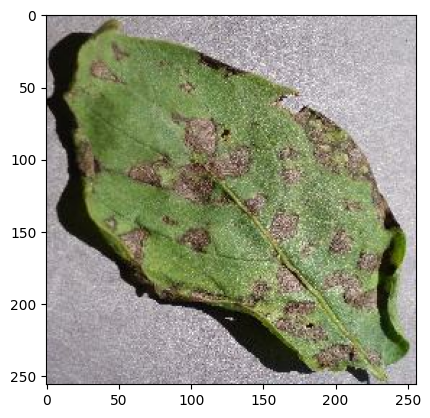

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


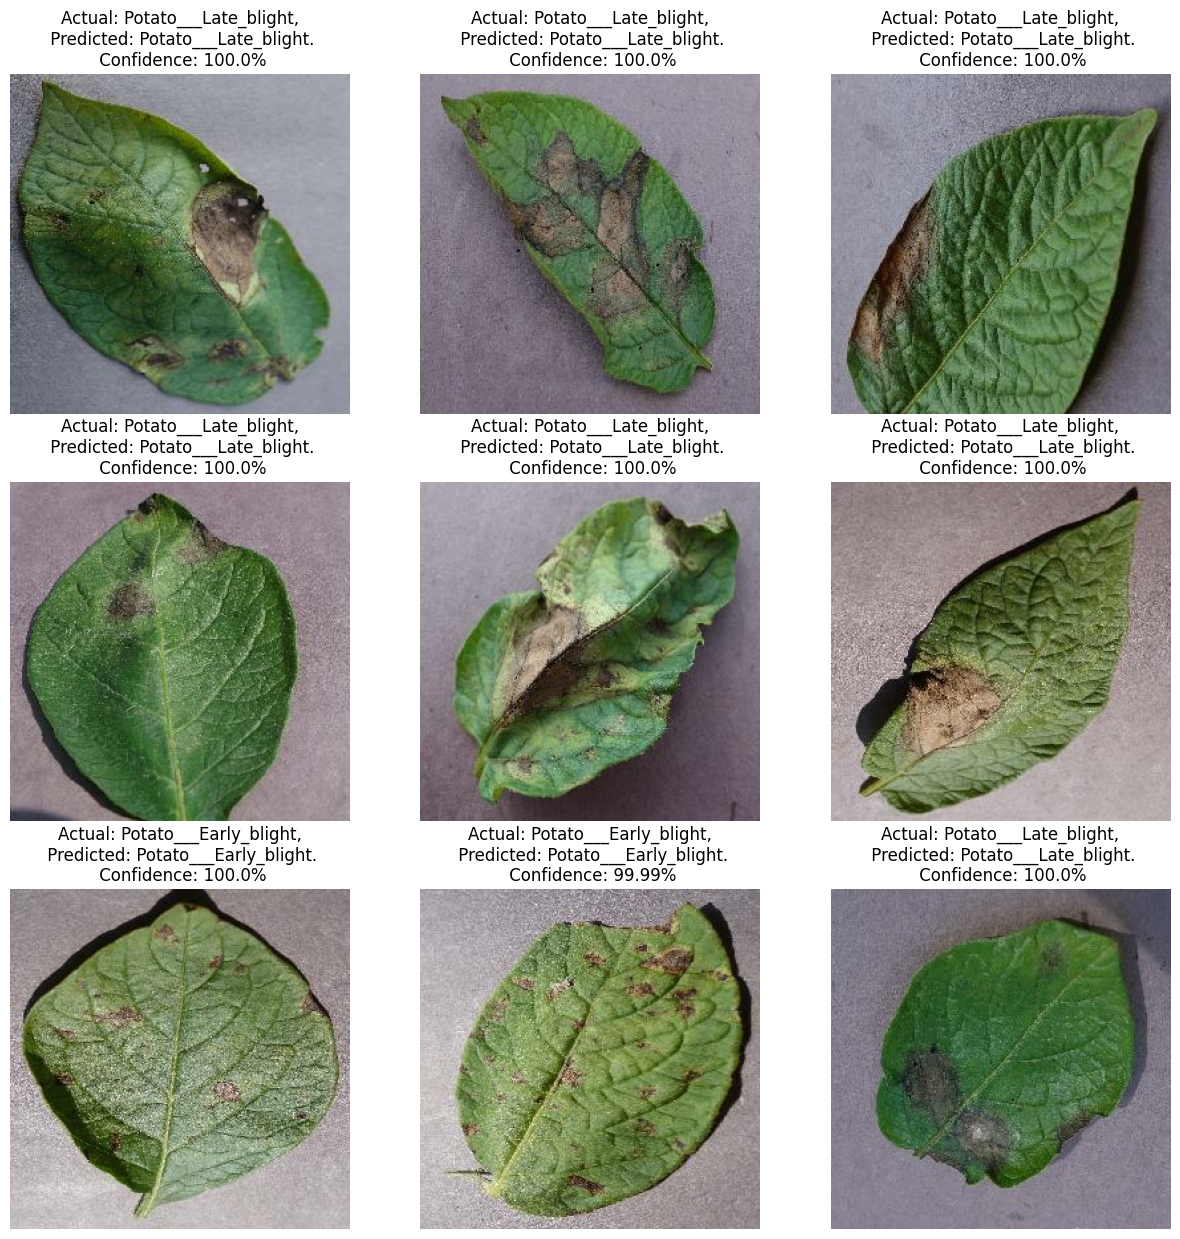

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [40]:
import os
models_dir = "../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
try:
    model_versions = [int(d) for d in os.listdir(models_dir) if d.isdigit()]
    model_version = max(model_versions + [0]) + 1
    model.save(os.path.join(models_dir, str(model_version)))
    print(f"Model saved successfully in {os.path.join(models_dir, str(model_version))}")
except Exception as e:
    print(f"An error occurred: {e}")

INFO:tensorflow:Assets written to: ../models\5\assets


INFO:tensorflow:Assets written to: ../models\5\assets


Model saved successfully in ../models\5


In [41]:
model.save("../potatoes.h5")